In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample



In [38]:
# 🔹 Step 1: Load Dataset
file_path = "water_leak_detection_1000_rows.csv"
df = pd.read_csv(file_path)



In [39]:
# 🔹 Step 2: Inspect Dataset (Check column names and missing values)
print(df.head())
print(df.info())
print(df['Leak Status'].value_counts())  # Check class imbalance


             Timestamp Sensor_ID  Pressure (bar)  Flow Rate (L/s)  \
0  2024-01-01 00:00:00      S007        3.694814        77.515218   
1  2024-01-01 00:05:00      S007        2.587125       179.926422   
2  2024-01-01 00:10:00      S002        2.448965       210.130823   
3  2024-01-01 00:15:00      S009        2.936844       141.777934   
4  2024-01-01 00:20:00      S003        3.073693       197.484633   

   Temperature (°C)  Leak Status  Burst Status  
0         21.695365            0             0  
1         19.016725            0             0  
2         10.011681            1             0  
3         12.092408            0             0  
4         17.001443            0             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Timestamp         1000 non-null   object 
 1   Sensor_ID         1000 non-null   object

In [40]:
#checking for missing values
df.isna().sum()

Timestamp           0
Sensor_ID           0
Pressure (bar)      0
Flow Rate (L/s)     0
Temperature (°C)    0
Leak Status         0
Burst Status        0
dtype: int64

In [41]:


# 🔹 Step 4: Balance Data (Up-sampling the minority class)
leak_df = df[df['Leak Status'] == 1]  # Leak class
non_leak_df = df[df['Leak Status'] == 0]  # Non-leak class

leak_upsampled = resample(leak_df, replace=True, n_samples=len(non_leak_df), random_state=42)
df_balanced = pd.concat([leak_upsampled, non_leak_df])


In [42]:
df_balanced.head()

,Timestamp,Sensor_ID,Pressure (bar),Flow Rate (L/s),Temperature (°C),Leak Status,Burst Status
394,2024-01-02 08:50:00,S007,2.219795,146.223197,20.533881,1,0
720,2024-01-03 12:00:00,S006,2.807886,71.443642,23.616031,1,0
430,2024-01-02 11:50:00,S009,1.847611,220.194048,13.009765,1,0
414,2024-01-02 10:30:00,S010,1.612130,147.909747,16.661916,1,0
394,2024-01-02 08:50:00,S007,2.219795,146.223197,20.533881,1,0


In [43]:
# Shuffle the DataFrame
shuffled_data = df_balanced.sample(frac=1, random_state=42)

shuffled_data.head()

,Timestamp,Sensor_ID,Pressure (bar),Flow Rate (L/s),Temperature (°C),Leak Status,Burst Status
116,2024-01-01 09:40:00,S006,3.096783,195.420565,22.982607,0,0
2,2024-01-01 00:10:00,S002,2.448965,210.130823,10.011681,1,0
483,2024-01-02 16:15:00,S001,2.128403,108.057013,19.330593,1,0
794,2024-01-03 18:10:00,S009,2.310686,143.518486,21.895945,1,0
520,2024-01-02 19:20:00,S009,2.638100,139.856688,19.354732,0,0


In [66]:

# 🔹 Step 5: Preprocess Data
X = shuffled_data.drop(columns=['Leak Status', 'Burst Status'])  # Features
y = shuffled_data['Leak Status']  # Target




In [67]:
# Identify columns with object dtype
print("Columns with object dtype:\n", X.select_dtypes(include=['object']).columns)

# Example: Convert date column to numerical format (timestamp)
X['Timestamp'] = pd.to_datetime(X['Timestamp'], errors='coerce').astype(int) / 10**9

# Example: Convert categorical column using one-hot encoding
X = pd.get_dummies(X, columns=['Timestamp', 'Sensor_ID'], drop_first=True)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Columns with object dtype:
 Index(['Timestamp', 'Sensor_ID'], dtype='object')


In [68]:
# 🔹 Step 6: Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [69]:

# 🔹 Step 7: Define ANN Model
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])


/home/ashley/Desktop/ann/myenve/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [70]:

# 🔹 Step 8: Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [71]:

# 🔹 Step 9: Train Model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))



Epoch 1/100


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8116 - loss: 0.3954 - val_accuracy: 1.0000 - val_loss: 0.1455
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9971 - loss: 0.0965 - val_accuracy: 1.0000 - val_loss: 0.0426
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9977 - loss: 0.0254 - val_accuracy: 1.0000 - val_loss: 0.0259
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 0.0242
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 0.0195
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.0181
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0177
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.

In [72]:
y_pred = model.predict(X_test)
y_pred

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


array([[9.9999911e-01],
       [6.6903146e-04],
       [2.0741523e-05],
       [9.9999839e-01],
       [3.0337974e-06],
       [5.3458399e-04],
       [5.7334796e-02],
       [9.9999845e-01],
       [6.7729488e-02],
       [4.1158783e-05],
       [9.9999970e-01],
       [9.9999928e-01],
       [9.9999893e-01],
       [1.2306729e-02],
       [9.9999923e-01],
       [9.9999911e-01],
       [9.9999958e-01],
       [9.9999946e-01],
       [3.2606713e-02],
       [4.3338261e-04],
       [1.5647589e-04],
       [3.7253485e-04],
       [9.9999911e-01],
       [1.5450057e-03],
       [1.9288505e-05],
       [9.9999923e-01],
       [2.6566890e-04],
       [9.9999970e-01],
       [9.9999970e-01],
       [3.7193417e-03],
       [9.5140189e-02],
       [9.9999923e-01],
       [9.9999970e-01],
       [9.9999952e-01],
       [9.9999923e-01],
       [9.9999839e-01],
       [9.1856401e-03],
       [1.4994013e-03],
       [8.1867934e-04],
       [1.9452114e-04],
       [9.9999887e-01],
       [9.999992

In [73]:
# 🔹 Step 10: Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0096 
Test Accuracy: 100.00%


In [74]:
# 🔹 Step 11: Save Model
model.save("leak_detection_ann.h5")


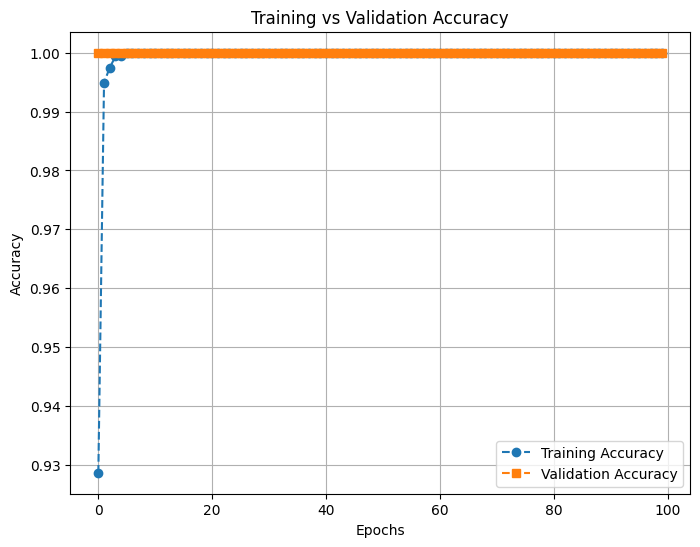

In [75]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned from model.fit()
plt.figure(figsize=(8, 6))

# Plot Training & Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='dashed', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='dashed', marker='s')

plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()
